In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from training.manifolds import Sphere
from training.metric import sphere_kl
from training.sampling import flow_sample, consistency_sample
from datasets.sphere_dataset import latlon_from_cartesian, Earthquake, Volcano, Fire, Flood

In [3]:
def plot_earth(latlon, title):
    """Scatter plot the points on the Earth"""
    lats, lons = latlon[:, 0], latlon[:, 1]
    fig = plt.figure(figsize=(12, 6))
    # m = Basemap(projection='ortho', lon_0=70, lat_0=20)
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
    m.fillcontinents(color='lightgray', lake_color='white')
    m.drawmapboundary(fill_color='white')  # White ocean background
    x, y = m(lons, lats)
    m.scatter(x, y, marker='o', color='red', edgecolor='none', s=5, alpha=0.3)
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.show()

Data size: torch.Size([6120, 1, 3])


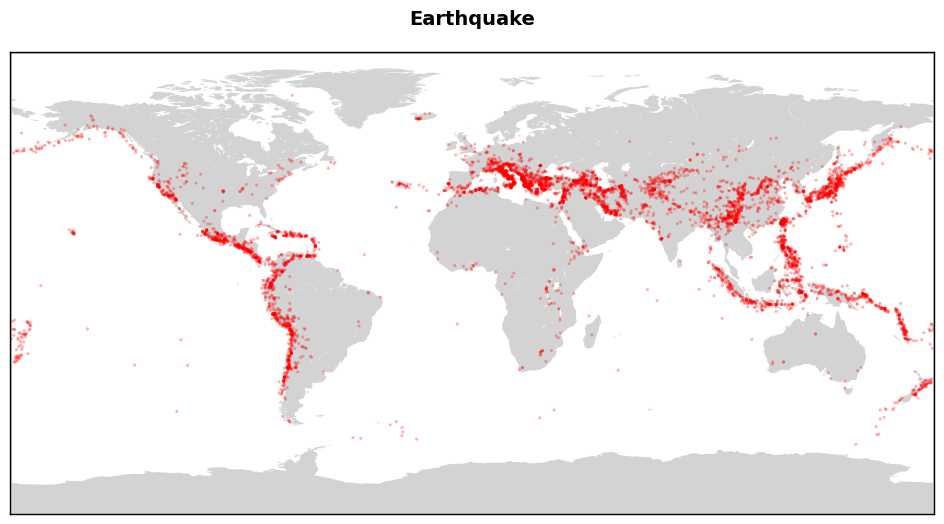

In [4]:
dataset = Earthquake('../data/sphere')  # Or Volcano, Fire, Flood
print(f'Data size:', dataset.data.size())
plot_earth(dataset.latlon.numpy(), 'Earthquake')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 181.75it/s]


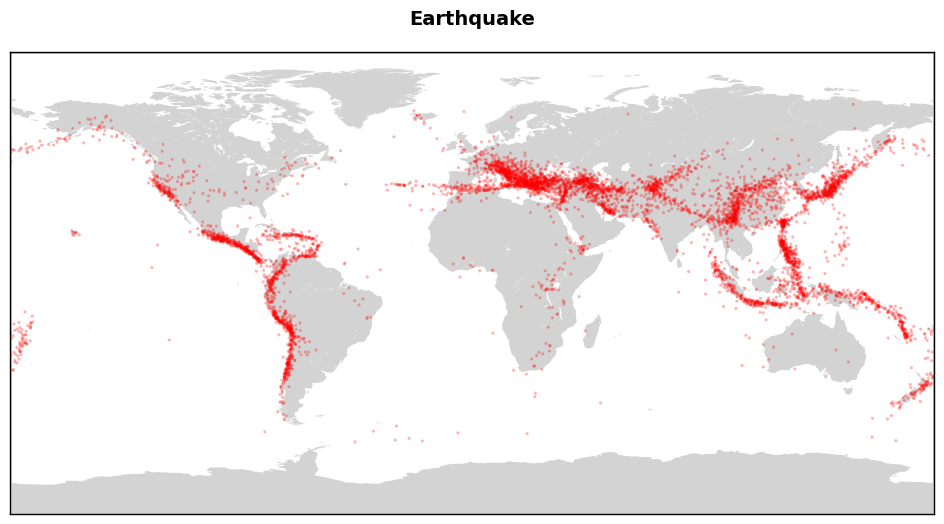

In [5]:
device = 'cuda:0'
ckpt_path = '../training-runs/00001-Earthquake-flow-gpus1-batch512/network-snapshot-050000.pkl'
n_steps = 100
with open(ckpt_path, 'rb') as f:
    rfm = pickle.load(f)['ema']
rfm.eval()
with torch.no_grad():
    # Here Sphere(3) is the data dimension but not the manifold dimension
    rfm_samples = flow_sample(rfm, Sphere(3), n_sample=len(dataset), n_steps=n_steps, device=device).squeeze(1).cpu()
plot_earth(latlon_from_cartesian(rfm_samples).numpy(), 'Earthquake')

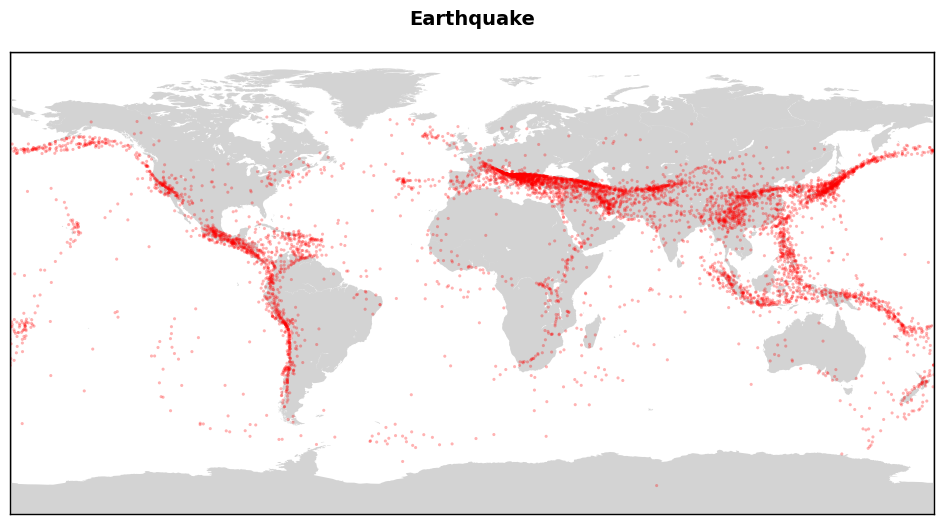

In [6]:
# Note that on such small datasets, RCD models can overfit quite early. An earlier checkpoint may be better in terms of KL.
device = 'cuda:0'
ckpt_path = '../consis-training-runs-sphere/00001-Earthquake-Continuous-consistency-gpus1-batch512/network-snapshot-004019.pkl'
with open(ckpt_path, 'rb') as f:
    rcd = pickle.load(f)['ema']
rcd.eval()
with torch.no_grad():
    rcd_samples = consistency_sample(rcd, Sphere(3), n_sample=len(dataset), n_steps=2, device=device).squeeze(1).cpu()
plot_earth(latlon_from_cartesian(rcd_samples).numpy(), 'Earthquake')

In [7]:
rfm_kl = sphere_kl(dataset.latlon, latlon_from_cartesian(rfm_samples), 90)
rcd_kl = sphere_kl(dataset.latlon, latlon_from_cartesian(rcd_samples), 90)
print(f'RFM-100 KL: {rfm_kl:.2f}, RCD-2 KL: {rcd_kl:.2f}')

RFM-100 KL: 1.496, RCD-2 KL: 2.243
